In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df_test = pd.read_csv('/home/kotik/PycharmProjects/test_lemmatized.csv')
df_train = pd.read_csv('/home/kotik/PycharmProjects/train_lemmatized.csv')

In [6]:
df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join('')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join('')

In [7]:
#df_train.lemmatized_text

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values) #переиндексация значений
y_test  = le.transform(df_test['label'].values)

In [ ]:
#X_train

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


#exp = expon(scale=2)
diap=np.arange(2,6,1)
NB_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('multiNB', MultinomialNB(class_prior=None))])
param_grid = {'tfidf__ngram_range':[(1,2)],
              'tfidf__sublinear_tf':[True],
              'tfidf__min_df':[2,3],
              'multiNB__alpha':[0.025,0.25], 
              #'multiNB__alpha':exp,
              'multiNB__fit_prior':[True]
              }

skf = StratifiedKFold(n_splits=5, random_state=42)
grid = RandomizedSearchCV(NB_pipeline,param_grid, n_iter=20, scoring='f1_macro', cv=skf)
grid_model = grid.fit(X_train, y_train)
grid_model.best_params_

/home/kotik/anaconda3/envs/naive_bayes/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'tfidf__sublinear_tf': True,
 'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 2,
 'multiNB__fit_prior': True,
 'multiNB__alpha': 0.025}

In [59]:
best_NB_pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df=2, sublinear_tf=True)), 
                        ('multiNB', MultinomialNB(alpha=0.025, class_prior=None, fit_prior=True))])

In [60]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

best_NB_pipeline.fit(X_train, y_train)
y_pred = best_NB_pipeline.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

Precision: 0.6162
Recall: 0.6299
f1-score: 0.6195


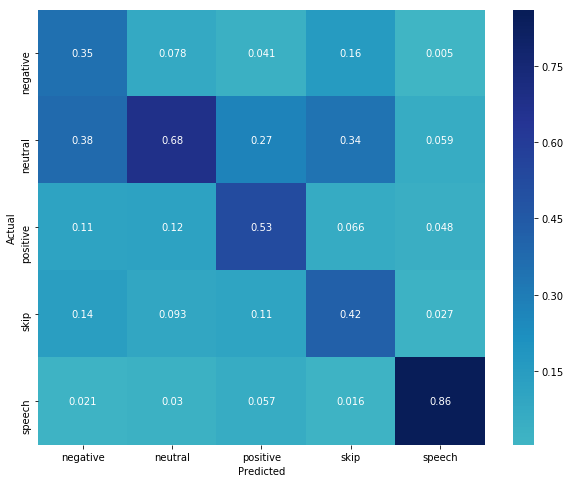

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0,cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [69]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

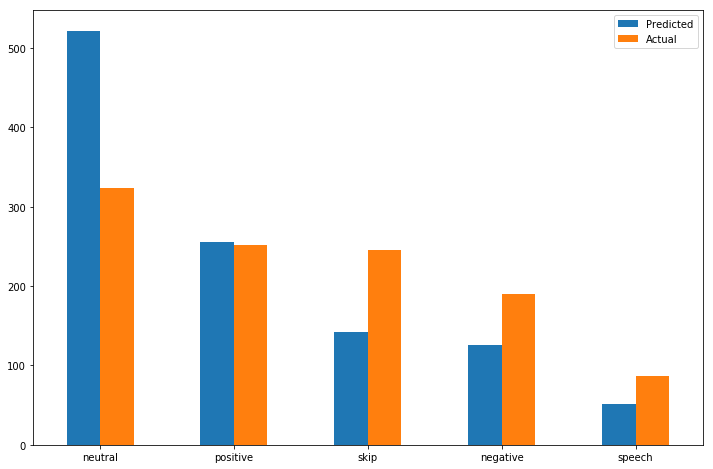

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [73]:
errors

,text,lemmatized_tokens,predicted,actual
0,"Александр, тебе к лицу эта пушка :)\n","['ты', 'к', 'лицо', 'этот', 'пушка']",positive,neutral
3,Мы просто с [id12210212|Елисеем] психанули )...,"['мы', 'просто', 'с', 'id12210212|елисей', 'пс...",positive,skip
5,Наши красавцы. 1:3 в первом периоде и 7:3 в ит...,"['наш', 'красавец', '1', '3', 'в', 'первый', '...",neutral,positive
8,"нельзя общаться с людьми, которые нуждаются в ...","['нельзя', 'общаться', 'с', 'человек', 'которы...",neutral,negative
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","['я', 'не', 'писать', 'такой', 'оскоблений', '...",negative,skip
18,...и так начало мини отпуска))И новых приключе...,"['...ь', 'так', 'начинать', 'минять', 'отпуск'...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"['кидать', 'в', 'чс', 'обижаться', 'холоп', 'п...",skip,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"['хороший', 'бы', 'в', 'таня', 'не', 'быть', '...",neutral,skip
23,и тебе няшку),"['и', 'ты', 'няшка']",speech,positive
26,без тебя_(,"['без', 'тебя']",positive,negative


10